<a href="https://colab.research.google.com/github/ajaytelukutla19/polygon_project/blob/main/polygon_shape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check for GPU availability
!nvidia-smi

# Install necessary libraries for deep learning and experiment tracking
!pip install torch torchvision
!pip install wandb



Tue Aug  5 17:18:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Mount Google Drive to access your dataset.
# You will be prompted to authorize this connection.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Verify the path to your dataset folder on Google Drive.
# Replace 'MyProject/dataset' with the actual path to your 'dataset' folder.
dataset_drive_path = '/content/drive/MyDrive/dataset'

# We'll create a symbolic link for convenience so the rest of the code works as-is.
!ln -s "{dataset_drive_path}" /content/dataset

# Verify the folder structure to ensure the path is correct
!ls /content/dataset/training/
!ls /content/dataset/validation/

Mounted at /content/drive
data.json  inputs  outputs
data.json  inputs  outputs


In [3]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import wandb

# --- Configuration ---
# Define your hyperparameters here.
config = {
    "learning_rate": 0.001,
    "batch_size": 32,
    "epochs": 100,
    "image_size": (128, 128),
    "in_channels": 3,
    "out_channels": 3,
    "features": [64, 128, 256, 512],
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Initialize wandb for this training run.
wandb.init(project="polygon-coloring-unet", config=config)
print(f"Using device: {config['device']}")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ajaytelukutla4583 (ajaytelukutla4583-vignan-s-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using device: cuda


In [4]:
# --- Dataset Class ---
class PolygonColoringDataset(Dataset):
    def __init__(self, data_root, json_file_path, all_colors=None, transform=None):
        self.data_root = data_root
        self.transform = transform

        with open(json_file_path, 'r') as f:
            self.data = json.load(f)

        # If no color list is provided, derive it from the current dataset
        if all_colors is None:
            all_colors = sorted(list(set(item['colour'] for item in self.data)))

        self.color_to_idx = {color: i for i, color in enumerate(all_colors)}
        self.num_colors = len(all_colors)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        input_image_path = os.path.join(self.data_root, 'inputs', item['input_polygon'])
        output_image_path = os.path.join(self.data_root, 'outputs', item['output_image'])

        input_image = Image.open(input_image_path).convert('RGB')
        output_image = Image.open(output_image_path).convert('RGB')

        color_name = item['colour']
        color_idx = self.color_to_idx[color_name]

        # Use the global number of colors (self.num_colors) for one-hot encoding
        color_one_hot = torch.zeros(self.num_colors)
        color_one_hot[color_idx] = 1

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        return {
            'input_image': input_image,
            'color_vector': color_one_hot,
            'target_image': output_image
        }

# --- Data Loading (CORRECTED) ---
data_root_dir = "/content/dataset/"
train_json_path = os.path.join(data_root_dir, 'training', 'data.json')
val_json_path = os.path.join(data_root_dir, 'validation', 'data.json')

image_transform = transforms.Compose([
    transforms.Resize(config['image_size']),
    transforms.ToTensor()
])

# First, create the training dataset to establish the canonical list of colors
train_dataset = PolygonColoringDataset(
    data_root=os.path.join(data_root_dir, 'training'),
    json_file_path=train_json_path,
    transform=image_transform
)

# Now, create the validation dataset and pass the color list from the training set
val_dataset = PolygonColoringDataset(
    data_root=os.path.join(data_root_dir, 'validation'),
    json_file_path=val_json_path,
    all_colors=sorted(list(train_dataset.color_to_idx.keys())),
    transform=image_transform
)

train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

# Update wandb config with the dynamically determined number of colors
wandb.config.update({"num_colors": train_dataset.num_colors})

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of unique colors (from training data): {train_dataset.num_colors}")

Number of training samples: 56
Number of validation samples: 5
Number of unique colors (from training data): 8


In [5]:
# --- UNet Model (with color conditioning) ---
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features, num_colors):
        super().__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.num_colors = num_colors

        # Encoder part
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)

        # Decoder part
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        # Final output layer
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

        # Color embedding for conditional input
        # This projects the one-hot color vector to a feature space
        self.color_embedding = nn.Linear(self.num_colors, features[0])

    def forward(self, image, color_vector):
        skip_connections = []

        # Encoder path
        x = image
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # Reverse the list for upsampling

        # Decoder path
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            # Ensure spatial dimensions match for concatenation
            if x.shape != skip_connection.shape:
                x = transforms.functional.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        # A simple fusion strategy: inject the color embedding into the final feature map
        color_emb = self.color_embedding(color_vector)
        color_emb = color_emb.view(color_emb.size(0), -1, 1, 1).expand(-1, -1, x.size(2), x.size(3))
        x = x + color_emb

        return self.final_conv(x)

# Instantiate the model and move it to the configured device (GPU if available)
model = UNet(
    in_channels=config['in_channels'],
    out_channels=config['out_channels'],
    features=config['features'],
    num_colors=wandb.config.num_colors
).to(config['device'])

In [6]:
# --- Training Loop (Corrected for NameError) ---
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)

# Optional: Add a learning rate scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

print("Starting training...")

# Define the number of epochs here
num_epochs = 50

for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0
    running_train_accuracy = 0.0

    for batch in train_loader:
        input_image = batch['input_image'].to(wandb.config.device)
        color_vector = batch['color_vector'].to(wandb.config.device)
        target_image = batch['target_image'].to(wandb.config.device)

        optimizer.zero_grad()
        outputs = model(input_image, color_vector)
        loss = criterion(outputs, target_image)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * input_image.size(0)

        thresholded_outputs = (outputs > 0.05).float()
        thresholded_targets = (target_image > 0.05).float()
        correct_pixels = (thresholded_outputs == thresholded_targets).sum().item()
        total_pixels = torch.numel(target_image)
        batch_accuracy = correct_pixels / total_pixels
        running_train_accuracy += batch_accuracy * input_image.size(0) # <-- Corrected line

    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    running_val_accuracy = 0.0

    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            input_image = batch['input_image'].to(wandb.config.device)
            color_vector = batch['color_vector'].to(wandb.config.device)
            target_image = batch['target_image'].to(wandb.config.device)

            outputs = model(input_image, color_vector)
            loss = criterion(outputs, target_image)
            running_val_loss += loss.item() * input_image.size(0)

            thresholded_outputs = (outputs > 0.05).float()
            thresholded_targets = (target_image > 0.05).float()
            correct_pixels = (thresholded_outputs == thresholded_targets).sum().item()
            total_pixels = torch.numel(target_image)
            batch_accuracy = correct_pixels / total_pixels
            running_val_accuracy += batch_accuracy * input_image.size(0) # <-- Corrected line

            # --- ENHANCED W&B IMAGE LOGGING ---
            if i == 0 and (epoch + 1) % 10 == 0:
                logged_image_gallery = []
                for j in range(min(4, input_image.shape[0])):
                    img_in = input_image[j]
                    raw_pred = outputs[j]

                    sharpened_pred = (raw_pred > 0.5).float()

                    final_pred = torch.clamp(raw_pred, 0, 1)

                    img_gt = target_image[j]

                    combined_image = torch.cat([img_in, raw_pred, sharpened_pred, final_pred, img_gt], dim=2)

                    logged_image_gallery.append(
                        wandb.Image(
                            combined_image,
                            caption=f"Sample {j+1}: Input | Raw | Sharpened (Binarized) | Final (Clamped) | Ground Truth"
                        )
                    )
                wandb.log({"Validation Predictions Gallery": logged_image_gallery})

    # Calculate average metrics for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_train_accuracy = running_train_accuracy / len(train_loader.dataset)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    epoch_val_accuracy = running_val_accuracy / len(val_loader.dataset)

    # scheduler.step(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_accuracy:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_accuracy:.4f}")

    wandb.log({
        "train_loss": epoch_train_loss,
        "train_accuracy": epoch_train_accuracy,
        "val_loss": epoch_val_loss,
        "val_accuracy": epoch_val_accuracy,
        "epoch": epoch
    })

# Save the final model weights
torch.save(model.state_dict(), "unet_polygon_coloring.pth")

# Finish the wandb run
wandb.finish()

Starting training...
Epoch [1/50] | Train Loss: 1.1227 | Train Acc: 0.3547 | Val Loss: 1.0762 | Val Acc: 0.2596
Epoch [2/50] | Train Loss: 0.8152 | Train Acc: 0.5874 | Val Loss: 0.9857 | Val Acc: 0.3263
Epoch [3/50] | Train Loss: 0.6241 | Train Acc: 0.7852 | Val Loss: 0.8510 | Val Acc: 0.4249
Epoch [4/50] | Train Loss: 0.4793 | Train Acc: 0.8519 | Val Loss: 0.7060 | Val Acc: 0.7288
Epoch [5/50] | Train Loss: 0.3642 | Train Acc: 0.8728 | Val Loss: 0.5559 | Val Acc: 0.8252
Epoch [6/50] | Train Loss: 0.2847 | Train Acc: 0.8823 | Val Loss: 0.4301 | Val Acc: 0.9336
Epoch [7/50] | Train Loss: 0.2224 | Train Acc: 0.8916 | Val Loss: 0.3296 | Val Acc: 0.9346
Epoch [8/50] | Train Loss: 0.1783 | Train Acc: 0.9038 | Val Loss: 0.2537 | Val Acc: 0.9346
Epoch [9/50] | Train Loss: 0.1353 | Train Acc: 0.9081 | Val Loss: 0.1952 | Val Acc: 0.9352


wandb: WARNING Data passed to `wandb.Image` should consist of values in the range [0, 255], image data will be normalized to this range, but behavior will be removed in a future version of wandb.


Epoch [10/50] | Train Loss: 0.1093 | Train Acc: 0.9091 | Val Loss: 0.1559 | Val Acc: 0.9351
Epoch [11/50] | Train Loss: 0.0870 | Train Acc: 0.9084 | Val Loss: 0.1310 | Val Acc: 0.9353
Epoch [12/50] | Train Loss: 0.0740 | Train Acc: 0.9084 | Val Loss: 0.1118 | Val Acc: 0.9351
Epoch [13/50] | Train Loss: 0.0650 | Train Acc: 0.9085 | Val Loss: 0.1004 | Val Acc: 0.9352
Epoch [14/50] | Train Loss: 0.0584 | Train Acc: 0.9083 | Val Loss: 0.0983 | Val Acc: 0.9339
Epoch [15/50] | Train Loss: 0.0569 | Train Acc: 0.9083 | Val Loss: 0.1197 | Val Acc: 0.9331
Epoch [16/50] | Train Loss: 0.0562 | Train Acc: 0.9084 | Val Loss: 0.1020 | Val Acc: 0.9325
Epoch [17/50] | Train Loss: 0.0547 | Train Acc: 0.9084 | Val Loss: 0.0988 | Val Acc: 0.9326
Epoch [18/50] | Train Loss: 0.0543 | Train Acc: 0.9084 | Val Loss: 0.1054 | Val Acc: 0.9331
Epoch [19/50] | Train Loss: 0.0538 | Train Acc: 0.9084 | Val Loss: 0.0918 | Val Acc: 0.9335
Epoch [20/50] | Train Loss: 0.0530 | Train Acc: 0.9084 | Val Loss: 0.0749 | Val 

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_accuracy,▁▄▆▇████████████████████████████████████
train_loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▆▇███████████████████████████████████
val_loss,█▇▆▅▄▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
train_accuracy,0.90837
train_loss,0.03613
val_accuracy,0.93427
val_loss,0.03267


In [8]:
def force_to_closest_color(tensor, color_palette):
    """
    Snap each pixel to the nearest color in the palette.
    Args:
        tensor: torch.Tensor of shape (3, H, W)
        color_palette: list of RGB color triplets in [0, 1] range
    Returns:
        Tensor with pixels snapped to closest palette color
    """
    H, W = tensor.shape[1], tensor.shape[2]
    flattened = tensor.view(3, -1).permute(1, 0)  # shape: (H*W, 3)

    # Convert palette to tensor
    palette_tensor = torch.tensor(color_palette).to(tensor.device)  # shape: (num_colors, 3)

    # Compute distances
    dists = ((flattened[:, None, :] - palette_tensor[None, :, :]) ** 2).sum(dim=2)  # (H*W, num_colors)
    closest = dists.argmin(dim=1)  # index of closest color

    # Assign closest color
    snapped = palette_tensor[closest]  # shape: (H*W, 3)
    return snapped.permute(1, 0).view(3, H, W)


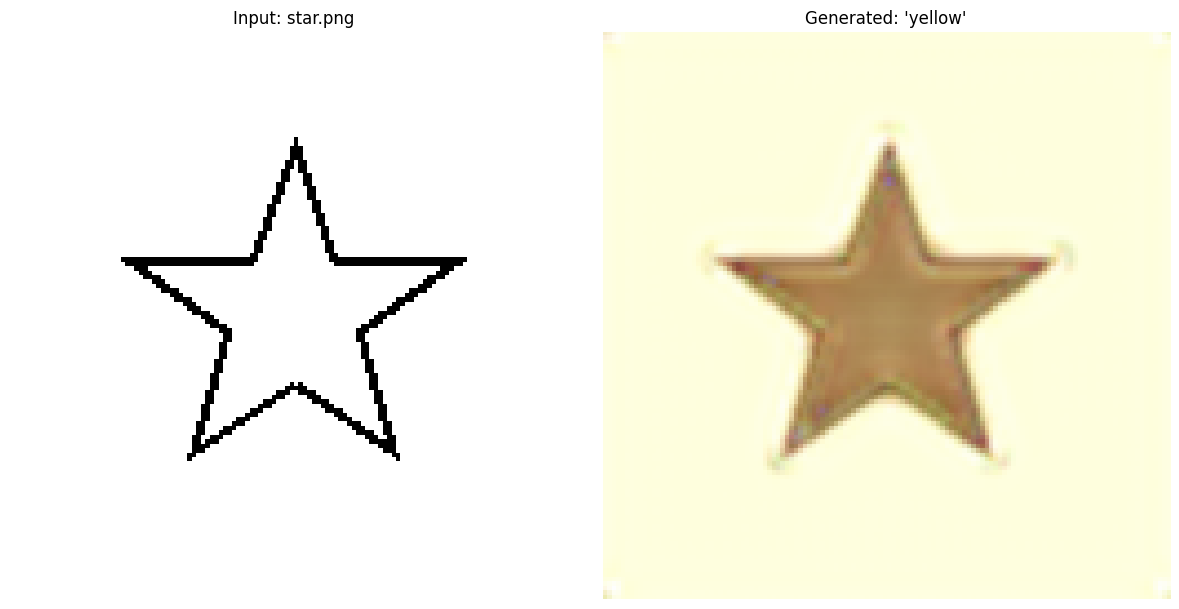

In [14]:
# --- Inference Script for UNet Polygon Coloring ---
def infer(model, image_path, color_name, all_colors, image_size, device):
    """Run inference on a given image and color with postprocessing."""
    # Load and preprocess input image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Encode target color
    color_to_idx = {color: idx for idx, color in enumerate(all_colors)}
    color_idx = color_to_idx[color_name]
    one_hot = torch.zeros(len(all_colors), device=device)
    one_hot[color_idx] = 1
    color_vector = one_hot.unsqueeze(0)  # shape: (1, num_colors)

    # Inference
    with torch.no_grad():
        output = model(image_tensor, color_vector)  # shape: (1, 3, H, W)
        output = torch.clamp(output, 0, 1)  # ensure pixel values in [0, 1]

        # Create mask of colored region (non-background)
        mask = (output > 0.1).float()  # threshold for keeping polygon color
        white_bg = torch.ones_like(output)  # white background

        # Apply mask: keep polygon color, replace rest with white
        output_cleaned = output * mask + white_bg * (1 - mask)

        # Optional: smoothen polygon edges (anti-aliasing)
        from torchvision.transforms.functional import gaussian_blur
        output_cleaned = gaussian_blur(output_cleaned, kernel_size=3)

    # Convert to PIL image for visualization
    output_image = transforms.ToPILImage()(output_cleaned.squeeze(0).cpu())

    return image, output_image


# --- Example Usage ---
polygon_path = "/content/dataset/validation/inputs/star.png"
target_color = "yellow"
all_colors = sorted(train_dataset.color_to_idx.keys())

input_img, output_img = infer(
    model=model,
    image_path=polygon_path,
    color_name=target_color,
    all_colors=all_colors,
    image_size=config['image_size'],
    device=config['device']
)

display_results(
    input_img=input_img,
    output_img=output_img,
    input_title=f"Input: {os.path.basename(polygon_path)}",
    output_title=f"Generated: '{target_color}'"
)


In [11]:
import matplotlib.pyplot as plt

def display_results(input_img, output_img, input_title="Input Image", output_title="Output Image"):
    """Helper function to display input and output images."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(input_img)
    axes[0].set_title(input_title)
    axes[0].axis('off')

    axes[1].imshow(output_img)
    axes[1].set_title(output_title)
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()